In [2]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import IPython.display
import cmocean as cm
import pandas as pd

from dask.distributed import Client, progress

import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata
print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.
Available exptdata keys:  ['1deg', '025deg', '01deg']


In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    #plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

## To deal with memory issues:
* In a terminal on VDI (either over VNC or through SSH and inside screen/tmux), run:
`dask-scheduler`
* This should output the scheduler address, like `tcp://10.0.64.24:8786`. 
* Now, in another terminal (ensuring that the default conda module has cosima_cookbook installed, as all workers will need access to that), run:
`dask-worker tcp://10.0.64.24:8786 --memory-limit 4e9 --nprocs 6 --nthreads 1 --local-directory /local/g40/amh157`
* Then, make sure the following cell matches the scheduler address.

In [4]:
client = Client('tcp://10.0.64.12:8786', local_dir='/local/g40/amh157')
client

Client Scheduler: tcp://10.0.64.12:8786 Dashboard: http://10.0.64.12:8787/status,Cluster Workers: 6 Cores: 6 Memory: 24.00 GB


In [21]:
%%time
ekey='1deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']


temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp',
                        chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset)

## This is the correct way to do this plot, but I don't have the right WOA13 data for now, 
# so am creating an alternative way for 1° output 
#temp_WOA13 = cc.get_nc_variable('woa13/10', 'woa13_ts_??_mom10.nc', 'temp').mean('time')
temp_WOA13 = cc.get_nc_variable('woa13/10_KDS50', 'ocean_temp_salt.res.nc', 'temp').mean('time')

# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13 = temp_WOA13.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13['st_ocean'] = temp.st_ocean
temp_WOA13['xt_ocean'] = temp.xt_ocean
temp_WOA13['yt_ocean'] = temp.yt_ocean
temp_WOA13 = temp_WOA13.astype(np.float32)

temp_anom = temp - temp_WOA13 - 273.15

area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1)
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum(['yt_ocean', 'xt_ocean']).load()

var =area_t*temp_anom
temp_hov = var.sum(['yt_ocean', 'xt_ocean']).load()
temp_hov_1deg = temp_hov/area_sum

IPython.display.clear_output()
temp_hov_1deg

CPU times: user 43.5 s, sys: 25.8 s, total: 1min 9s
Wall time: 1min 23s


In [7]:
%%time
ekey='025deg'
expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']
temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp', chunks={'st_ocean': None}, n=n_files,
                        time_units=time_units, offset=offset)
temp_WOA13 = cc.get_nc_variable('woa13/025_KDS50', 'woa13_ts_??_mom025.nc', 'temp').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13 = temp_WOA13.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13['st_ocean'] = temp.st_ocean
temp_WOA13['xt_ocean'] = temp.xt_ocean
temp_WOA13['yt_ocean'] = temp.yt_ocean

temp_WOA13 = temp_WOA13.astype(np.float32)

temp_anom = temp - temp_WOA13 - 273.15

area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1)
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum(['yt_ocean', 'xt_ocean']).load()

var =area_t*temp_anom
temp_hov = var.sum(['yt_ocean', 'xt_ocean']).load()
temp_hov_025deg = temp_hov/area_sum

IPython.display.clear_output()

CPU times: user 1min 29s, sys: 30.3 s, total: 2min
Wall time: 5min 46s


In [4]:
%%time
ekey='01deg'
chunks={'st_ocean':None, 'xt_ocean': 400, 'yt_ocean': 300}

expt = exptdata.exptdict[ekey]['expt']
n_files = exptdata.exptdict[ekey]['n_files']
time_units = exptdata.exptdict[ekey]['time_units']
offset = exptdata.exptdict[ekey]['offset']

temp = cc.get_nc_variable(expt, 'ocean.nc', 'temp', chunks=chunks, n=n_files,
                        time_units=time_units, offset=offset)
print(temp)

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
<xarray.DataArray 'temp' (time: 396, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<shape=(396, 75, 2700, 3600), dtype=float32, chunksize=(1, 75, 300, 400)>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 1985-01-14T12:00:00 ... 2017-12-14T12:00:00
Attributes:
    long_name:      Potential temperature
    units:          degrees K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    coordinates:    geolon_t geolat_t
    standard_name:  sea_water_potential_temperature
CPU times: user 15.4 s, sys: 9.28 s, total: 24.7 s
Wall time: 34.7 s


In [5]:
%%time
temp_WOA13 = cc.get_nc_variable('woa13/01', 'woa13_ts_??_mom01.nc', 'temp').mean('time')
# hacky renaming of variables so we can use as a dask array -- there's probably an elegant way to do this
temp_WOA13 = temp_WOA13.rename({'GRID_Y_T': 'yt_ocean', 'GRID_X_T': 'xt_ocean', 'ZT': 'st_ocean'})
temp_WOA13['st_ocean'] = temp.st_ocean
temp_WOA13['xt_ocean'] = temp.xt_ocean
temp_WOA13['yt_ocean'] = temp.yt_ocean

# force calculation and save to disk -- we could probably skip the .load() and write directly
temp_WOA13.to_netcdf('/local/g40/amh157/woa13.nc')

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 29 s, sys: 10.4 s, total: 39.4 s
Wall time: 7min 8s


In [6]:
%%time
# rechunk to match ocean.nc data
temp_WOA13 = xr.open_dataset('/local/g40/amh157/woa13.nc', chunks=chunks).temp
temp_WOA13 = temp_WOA13.astype(np.float32)

temp_anom = temp - temp_WOA13 - 273.15
print(temp_anom)

<xarray.DataArray 'temp' (time: 396, st_ocean: 75, yt_ocean: 2700, xt_ocean: 3600)>
dask.array<shape=(396, 75, 2700, 3600), dtype=float32, chunksize=(1, 75, 300, 400)>
Coordinates:
  * xt_ocean  (xt_ocean) float64 -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * st_ocean  (st_ocean) float64 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * yt_ocean  (yt_ocean) float64 -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 1985-01-14T12:00:00 ... 2017-12-14T12:00:00
CPU times: user 48 ms, sys: 25 ms, total: 73 ms
Wall time: 135 ms


In [7]:
%%time
area_t = cc.get_nc_variable(expt,'ocean_grid.nc','area_t',n=1,chunks={'xt_ocean': 400, 'yt_ocean': 300})
mask = temp.isel(time=0).copy()
mask = mask/mask                 ## This seems pretty dodgy to me, but it works!!
area = mask*area_t
area_sum = area.sum(['yt_ocean', 'xt_ocean']).load()

Using database sqlite:////g/data3/hh5/tmp/cosima/cosima-cookbook/cosima-cookbook.db
CPU times: user 15.1 s, sys: 9.2 s, total: 24.3 s
Wall time: 33.6 s


In [8]:
%%time
var =area_t*temp_anom
temp_hov = var.sum(['yt_ocean', 'xt_ocean'])

CPU times: user 469 ms, sys: 4 ms, total: 473 ms
Wall time: 470 ms


In [9]:
# This bit not working for me any longer?
#x=temp_hov.persist()
#progress(x)

VBox()

In [9]:
%%time
temp_hov_01deg = temp_hov/area_sum
temp_hov_01deg.load()

CPU times: user 2min 58s, sys: 21.8 s, total: 3min 19s
Wall time: 19h 59min 25s


In [18]:
%%time
#temp_hov.to_netcdf('/local/g40/amh157/temp_hov.nc')
#temp_hov_01deg.to_netcdf('/local/g40/amh157/temp_hov_01deg.nc')
temp_hov_01deg = xr.open_dataarray('/local/g40/amh157/temp_hov_01deg.nc')

CPU times: user 8 ms, sys: 3 ms, total: 11 ms
Wall time: 9.01 ms


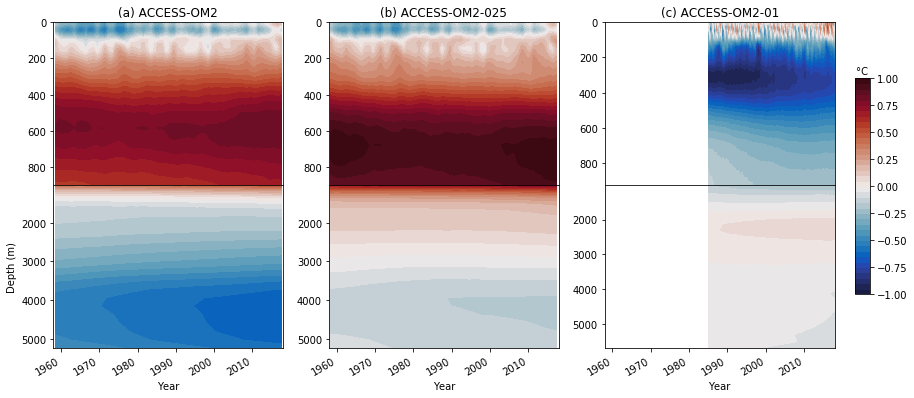

In [23]:
fig,ax = plt.subplots(2,3,sharex=True,figsize=(14,6))
plt.subplots_adjust(hspace=0)
levs = np.arange(-1.0,1.0001,0.05)

# 1deg
t_up = temp_hov_1deg.sel(st_ocean=slice(0,1000))
t_lo = temp_hov_1deg.sel(st_ocean=slice(1000,6000))

axx=ax[0,0]
t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_title('(a) ACCESS-OM2')
axx=ax[1,0]
p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('Depth (m)')
axx.set_xlabel('Year')

# 025deg
t_up = temp_hov_025deg.sel(st_ocean=slice(0,1000))
t_lo = temp_hov_025deg.sel(st_ocean=slice(1000,6000))

axx=ax[0,1]
t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('')
axx.set_title('(b) ACCESS-OM2-025')
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
axx=ax[1,1]
p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('Year')
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])

# 01deg
t_up = temp_hov_01deg.sel(st_ocean=slice(0,1000))
t_lo = temp_hov_01deg.sel(st_ocean=slice(1000,6000))

axx=ax[0,2]
t_up.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('')
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])
axx.set_title('(c) ACCESS-OM2-01')
axx=ax[1,2]
p1=t_lo.T.plot.contourf(ax=axx,levels=levs,cmap = cm.cm.balance,yincrease=False,add_colorbar=False)
axx.set_ylabel('')
axx.set_xlabel('Year')
plt.xlim([pd.datetime(1958,1,1),pd.datetime(2017,12,31)])

ax1 = plt.axes([0.92,0.25,0.015,0.5])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('°C')

savefigure('tz_hovmoller')